# Load the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Load the dataset

In [2]:
# Load the prepared 1M dataset
file_path = r'C:\Users\Nandan Hegde\OneDrive\Documents\GitHub\MSU_STT810_Semester_projects\E-commerce_recommendation\Interim_Data\sampled_df.csv'
data = pd.read_csv(file_path)

# Processing the dataset

C:\Users\Nandan Hegde\AppData\Local\Temp\ipykernel_18952\1407401135.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['brand'].fillna('unknown', inplace=True)  # Impute missing brands with "unknown"


Duplicates removed: 0
Invalid prices removed: 4959
Final dataset shape after preprocessing: (934646, 22)
Remaining missing values:
 Unnamed: 0                0
event_time                0
event_type                0
product_id                0
category_id               0
brand                     0
price                     0
user_id                   0
user_session              0
month                     0
event_month               0
normalized_price          0
price_category            0
event_hour                0
event_day_of_week         0
temporal_weight           0
total_events              0
count_cart                0
count_purchase            0
count_remove_from_cart    0
count_view                0
log_price                 0
dtype: int64
Enhanced dataset saved as enhanced_1M_dataset.pkl


C:\Users\Nandan Hegde\AppData\Local\Temp\ipykernel_18952\1407401135.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='event_type', data=data, palette='viridis')


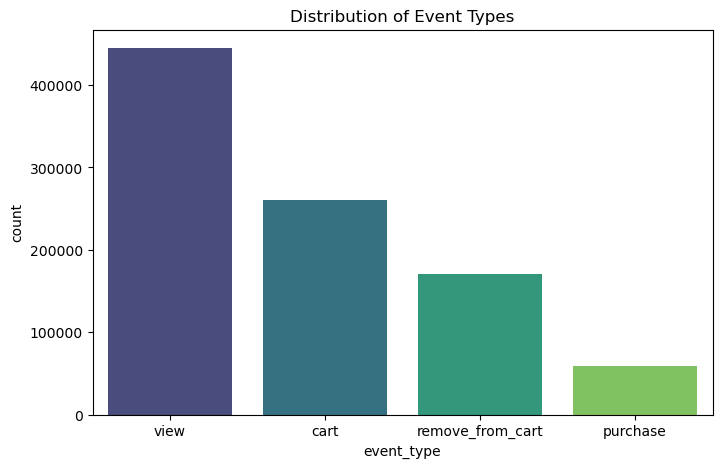

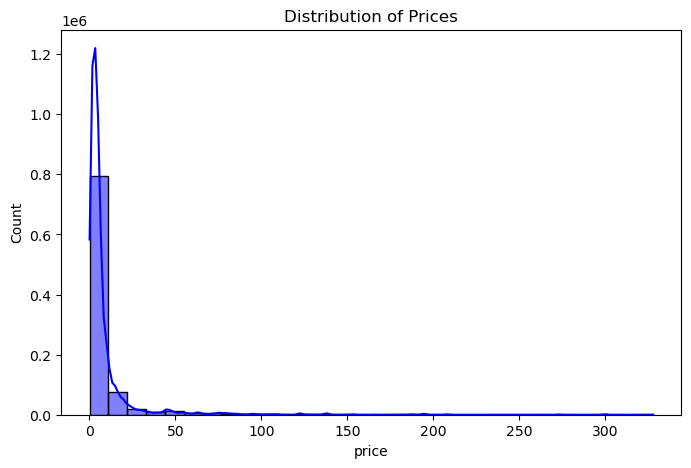

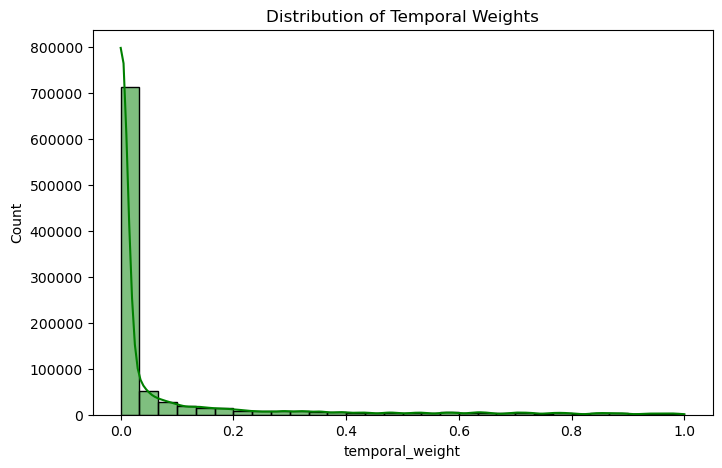

In [3]:
# Convert `event_time` to datetime
data['event_time'] = pd.to_datetime(data['event_time'])

# Step 1: Handle Missing Values
data.drop(columns=['category_code'], inplace=True)  # Drop `category_code` (too many missing values)
data['brand'].fillna('unknown', inplace=True)  # Impute missing brands with "unknown"
data.dropna(subset=['user_session'], inplace=True)  # Drop rows with missing sessions

# Step 2: Remove Duplicates
initial_shape = data.shape
data.drop_duplicates(inplace=True)
print(f"Duplicates removed: {initial_shape[0] - data.shape[0]}")

# Step 3: Clean `price` Column
invalid_prices = data[(data['price'] <= 0) | (data['price'] > 1000)].shape[0]
data = data[(data['price'] > 0) & (data['price'] <= 1000)]
print(f"Invalid prices removed: {invalid_prices}")

# Step 4: Normalize Prices
scaler = MinMaxScaler()
data['normalized_price'] = scaler.fit_transform(data[['price']])

# Step 5: Price Categories
def categorize_price(price):
    if price < 20:
        return 'Low'
    elif 20 <= price <= 50:
        return 'Medium'
    else:
        return 'High'

data['price_category'] = data['price'].apply(categorize_price)

# Step 6: Time-Based Features
data['event_hour'] = data['event_time'].dt.hour
data['event_day_of_week'] = data['event_time'].dt.day_name()

# Step 7: Temporal Decay Weights (Exponential Decay)
current_time = data['event_time'].max()
data['temporal_weight'] = np.exp(-0.1 * (current_time - data['event_time']).dt.total_seconds() / 86400)

# Step 8: User Behavior Metrics
user_event_counts = data.groupby('user_id')['event_type'].count().reset_index()
user_event_counts.columns = ['user_id', 'total_events']

# Diversity of interactions
interaction_types = data.pivot_table(index='user_id', columns='event_type', aggfunc='size', fill_value=0)
interaction_types.columns = [f"count_{col}" for col in interaction_types.columns]

user_behavior = user_event_counts.merge(interaction_types, on='user_id')

# Step 9: Merge User and Product Metrics
data = data.merge(user_behavior, on='user_id', how='left')

# Step 10: Log Transform Prices (for Price Sensitivity Analysis)
data['log_price'] = np.log(data['price'] + 1)

# Step 11: Final Dataset Summary
print("Final dataset shape after preprocessing:", data.shape)
print("Remaining missing values:\n", data.isnull().sum())

# Save Enhanced Dataset
data.to_pickle(r'C:\Users\Nandan Hegde\OneDrive\Documents\GitHub\MSU_STT810_Semester_projects\E-commerce_recommendation\enhanced_1M_dataset.pkl')
print("Enhanced dataset saved as enhanced_1M_dataset.pkl")

# Optional: Visualization for Distributions
plt.figure(figsize=(8, 5))
sns.countplot(x='event_type', data=data, palette='viridis')
plt.title("Distribution of Event Types")
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(data['price'], kde=True, bins=30, color='blue')
plt.title("Distribution of Prices")
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(data['temporal_weight'], kde=True, bins=30, color='green')
plt.title("Distribution of Temporal Weights")
plt.show()

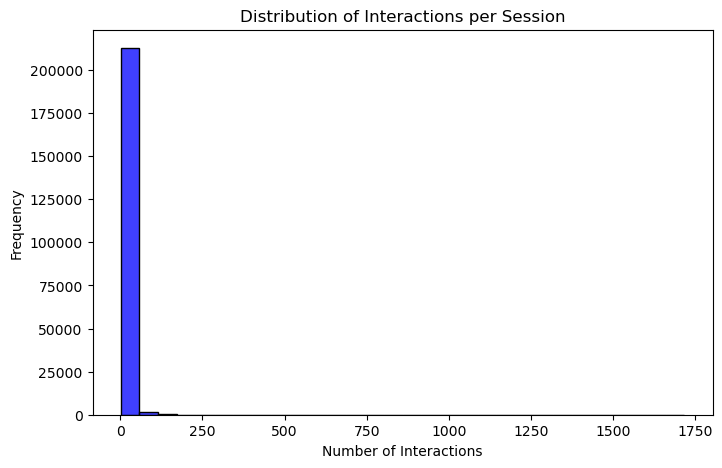

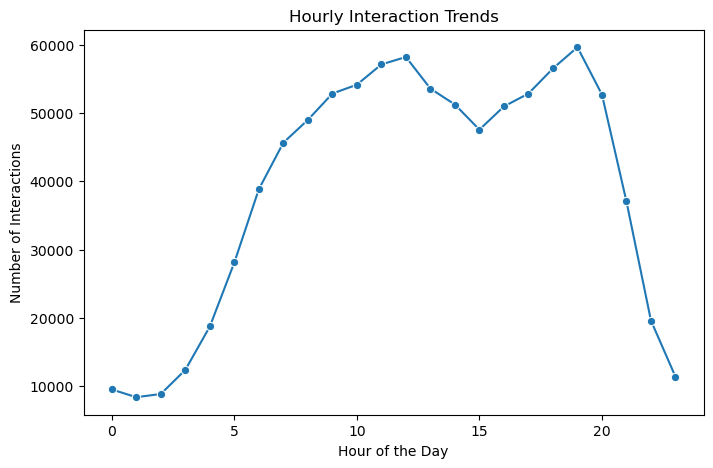

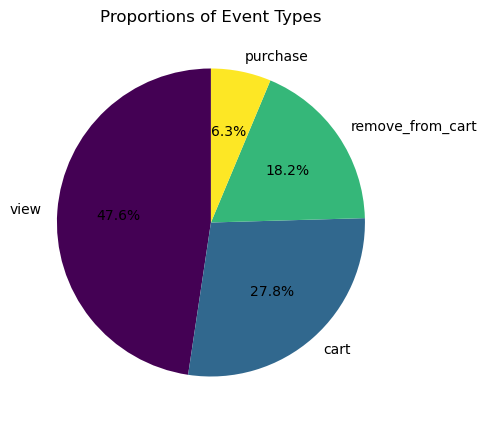

C:\Users\Nandan Hegde\AppData\Local\Temp\ipykernel_18952\2340219062.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_brands.values, y=top_brands.index, palette='viridis')


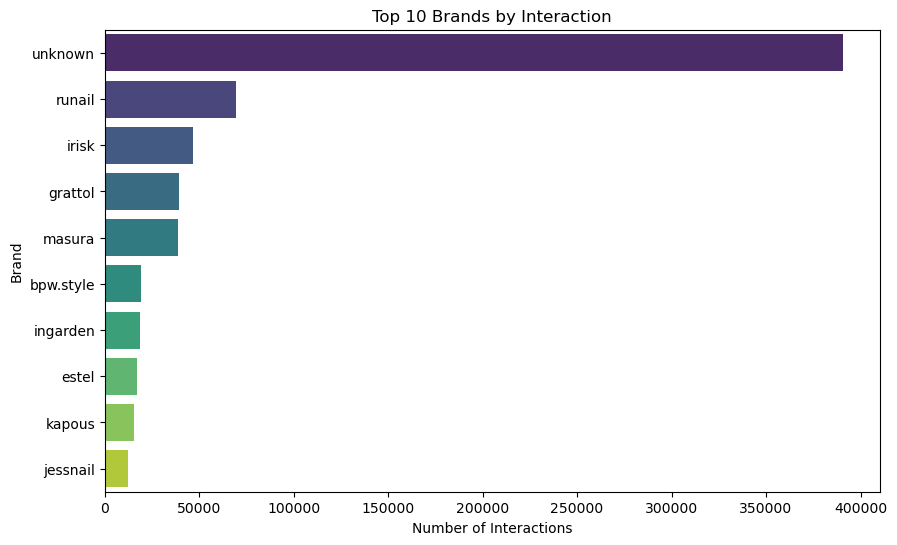

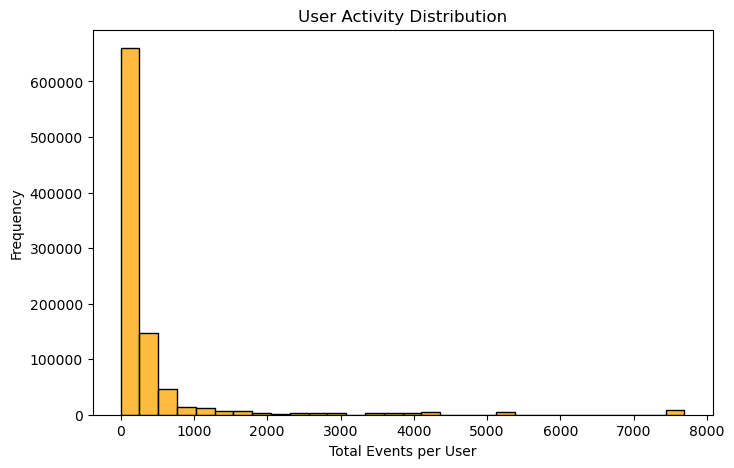

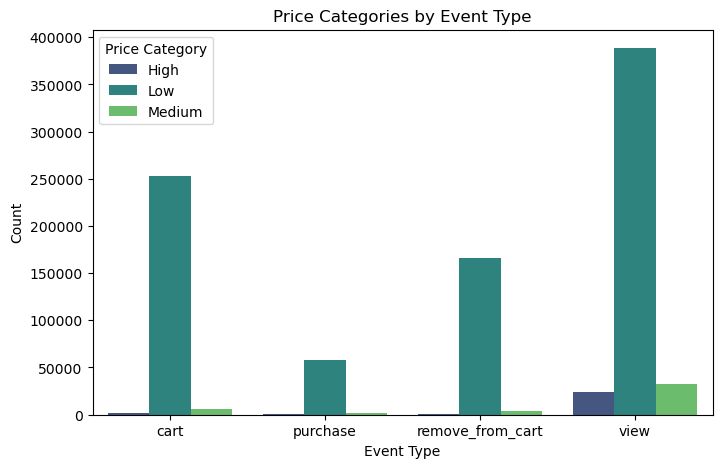

In [4]:
# 1. Session Activity
plt.figure(figsize=(8, 5))
session_activity = data['user_session'].value_counts()
sns.histplot(session_activity, bins=30, kde=False, color='blue')
plt.title("Distribution of Interactions per Session")
plt.xlabel("Number of Interactions")
plt.ylabel("Frequency")
plt.show()

# 2. Hourly Interaction Trends
plt.figure(figsize=(8, 5))
hourly_trends = data.groupby('event_hour')['event_type'].count()
sns.lineplot(x=hourly_trends.index, y=hourly_trends.values, marker='o')
plt.title("Hourly Interaction Trends")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Interactions")
plt.show()

# 3. Event Type Proportions
plt.figure(figsize=(8, 5))
event_proportions = data['event_type'].value_counts(normalize=True)
event_proportions.plot(kind='pie', autopct='%1.1f%%', startangle=90, colormap='viridis')
plt.title("Proportions of Event Types")
plt.ylabel("")  # Remove default y-axis label
plt.show()

# 4. Top Brands by Interaction
plt.figure(figsize=(10, 6))
top_brands = data['brand'].value_counts().head(10)
sns.barplot(x=top_brands.values, y=top_brands.index, palette='viridis')
plt.title("Top 10 Brands by Interaction")
plt.xlabel("Number of Interactions")
plt.ylabel("Brand")
plt.show()

# 5. User Activity Distribution
plt.figure(figsize=(8, 5))
sns.histplot(data['total_events'], bins=30, kde=False, color='orange')
plt.title("User Activity Distribution")
plt.xlabel("Total Events per User")
plt.ylabel("Frequency")
plt.show()

# 6. Price Categories by Event Type
plt.figure(figsize=(8, 5))
price_event_dist = data.groupby(['event_type', 'price_category']).size().reset_index(name='count')
sns.barplot(data=price_event_dist, x='event_type', y='count', hue='price_category', palette='viridis')
plt.title("Price Categories by Event Type")
plt.xlabel("Event Type")
plt.ylabel("Count")
plt.legend(title="Price Category")
plt.show()